Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

Tweakable:
* test-time augmentation
* flattening B-, I-
* block-size
* batch-size
* gradient

Experiments:
* (negation paper) 32 block size, 32 batch size, with/without centered validation
  * MedRoBERTa.nl
  * RobBERT v2
* 32 block size, 32 batch size, with centered validation, 1-12 layers 
  * MedRoBERTa.nl
  * RobBERT v2

In [2]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import dotenv
import numpy as np
import random
from tqdm import tqdm

try:
    from torch.nn import CrossEntropyLoss
except ImportError:
    # load .env
    dotenv.load_dotenv(dotenv.find_dotenv())
    os.environ['LD_LIBRARY_PATH'] = os.getenv('LD_LIBRARY_PATH')
    from torch.nn import CrossEntropyLoss
    

from torch.utils.data import Dataset, DataLoader
from torch import device, cuda, version

#import apex
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple
from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification
from transformers import AutoModelForSequenceClassification

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import dcc_splitter as splitter
from utils import ner_training as trainer
#import dcc_splitter as splitter

use_gpu = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [4]:
if cuda.is_available():
    print('CUDA, GPU, is working')
    os.system("espeak 'CUDA, GPU, is working!'")
else:
    print('CUDA, GPU, is not working')
    os.system("espeak 'CUDA, GPU, is NOT working!'")
    
device = device("cuda:0") if (cuda.is_available()) & (use_gpu==True) else device("cpu")

CUDA, GPU, is working


In [5]:
base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"

dcc_dir = None
output_dir = os.path.join(base_folder, "finetuned")
skip_file = None
n_splits = 10
random_state = None
reduce_tags = False
centered_testing = True
train_on_all = True
zero_shot = False # do not train the attention layers, only the final linear layer
num_trainable_layers = None # None: all, overrides zero_shot
base_folder = "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models"
mod_name = "MedRoBERTa" #"robbert-v2-dutch-base-DAPT" # "robbert-v2-dutch-base" # belabBERT_115k # bert-base-dutch, #MedRoBERTa # robbert-v2-dutch-base-DAPT # medroberta_journals_ARGUS_nvvc_IBD_RA
mod_name = "base/medroberta" #"robbert-v2-dutch-base-DAPT" # "robbert-v2-dutch-base" # belabBERT_115k # bert-base-dutch, #MedRoBERTa # robbert-v2-dutch-base-DAPT # medroberta_journals_ARGUS_nvvc_IBD_RA
 

args = namedtuple
args.task = "experiencer" # experiencer, temporality, negation
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje 
args.num_epochs = 5 # 10 for zero-shot
args.eval_steps = 500 
args.lr =  1e-4 # 5e-5 for non-zeroshot 64 bs, 5e-3 for zero-shot 128 bs, 1e-4 for nonzeroshot 32 bs
args.batch_size= 32 #4
args.gradient_accumulation_steps = 1 #16
args.block_size = 64 # 512 
args.save_model=False
args.bio=True
args.do_eval=False
args.do_write=True
args.bootstrap=False
args.do_print_class_report=False
args.amp=True

mod_name = mod_name.replace("/","_").replace("-","_")+"_"+"_".join([str(args.num_epochs), 
                                                   str(args.batch_size*args.gradient_accumulation_steps), 
                                                   str(args.block_size),
                                                   "zeroShot" if zero_shot else "",
                                                   "centeredVal" if centered_testing else "",
                                                   args.task])
mod_name = mod_name.strip("_")
output_folder = "fine_tuned_token_"+args.task+"_"+mod_name

args.output_dir = os.path.join(output_dir, output_folder)


random.seed(77)

In [6]:
# args.block_size determines how many text snippets are  used for training, see ner_training.py lines 118--141
# obviously this is a code-design flaw that should be mended.
# the dataset loader should  include the id_begin_end in the output

In [15]:
# dcc-splitter for folds
dcc_splitter = splitter.DCCSplitter(dcc_dir, output_dir, skip_file, n_splits, random_state, write_to_file=False)
splits = dcc_splitter.split()

In [16]:
# load NER DCC set
dcc = pd.read_csv("../data/RobBERT/DCC_df.csv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="latin1",
                  on_bad_lines='warn', 
                  keep_default_na=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/RobBERT/DCC_df.csv'

In [10]:
dcc.Temporality.value_counts()

Temporality
O               139764
Recent           18859
Historical         811
Hypothetical       169
Name: count, dtype: int64

In [8]:
dcc.Negation.value_counts()

Negation
O             139764
NotNegated     16781
Negated         3058
Name: count, dtype: int64

In [9]:
dcc.Temporality.value_counts()

Temporality
O               139764
Recent           18859
Historical         811
Hypothetical       169
Name: count, dtype: int64

In [10]:
dcc.Experiencer.value_counts()

Experiencer
O          139764
Patient     19673
Other         166
Name: count, dtype: int64

In [11]:
dcc.BIO.value_counts()

BIO
O    139764
B     11971
I      7868
Name: count, dtype: int64

In [12]:
dcc.loc[dcc.BIO!='O'][['Id', 'Begin', 'End']].apply(lambda x: "_".join(str(x)), axis=1).nunique()

19839

In [13]:
Texts = dcc.groupby('Id').Word.apply(lambda x: " ".join(x))

In [14]:
if reduce_tags:
    tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':0,'I-NotNegated':1},
              'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':0,
                             'I-Historical':1,'I-Hypothetical':2},
              'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':0,'I-Other':1}}
else:
    tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
              'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,
                             'I-Historical':4,'I-Hypothetical':5},
              'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

In [15]:
dcc['num_tokens'] = dcc.Word.apply(lambda x: len(tokenizer.tokenize(x)))
dcc['cumsum_tokens'] = dcc.groupby('Id').num_tokens.cumsum()
dcc['letter_type'] = dcc.Id.str.slice(0,2)
tokens_df = dcc.groupby(['Id', 'letter_type']).cumsum_tokens.agg(num_tokens=max).reset_index()

/tmp/ipykernel_158259/3011909158.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  tokens_df = dcc.groupby(['Id', 'letter_type']).cumsum_tokens.agg(num_tokens=max).reset_index()


Mean 
DL tokens: 51.27199191102123
SP tokens :52.58494404883011
RD tokens :31.180240320427238
GP tokens :28.964116094986807


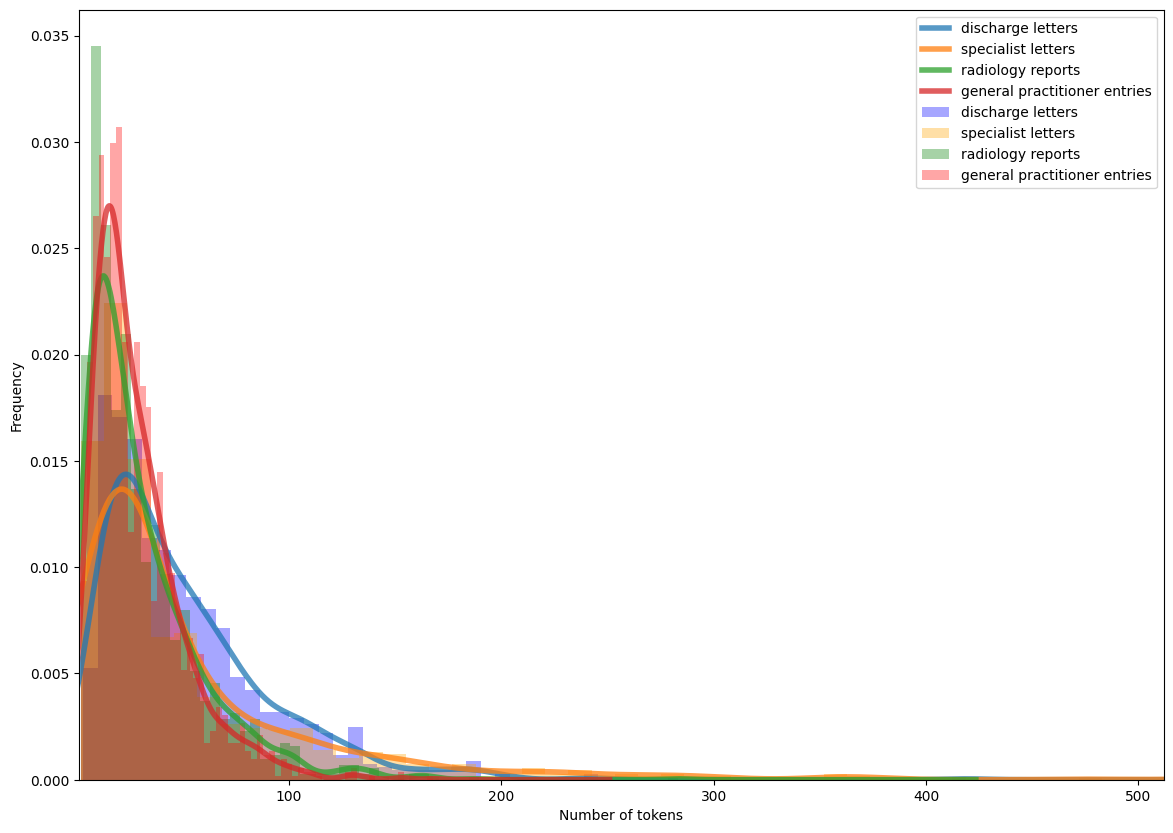

In [16]:
plt.figure(figsize=(14,10))
tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='general practitioner entries')

tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='blue',
                                              label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='orange',
                                              label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='green',
                                              label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='red',
                                              label='general practitioner entries')


plt.legend()
#plt.semilogx()
plt.xlabel("Number of tokens")
plt.xlim(1,512)

print(f"Mean \nDL tokens: {tokens_df[(tokens_df.letter_type=='DL')].num_tokens.mean()}\n\
SP tokens :{tokens_df[(tokens_df.letter_type=='SP')].num_tokens.mean()}\n\
RD tokens :{tokens_df[(tokens_df.letter_type=='RD')].num_tokens.mean()}\n\
GP tokens :{tokens_df[(tokens_df.letter_type=='GP')].num_tokens.mean()}")

In [17]:
# find I that is not preceeded by a B..
def prior_equal_to(x, equal_to='O'):
    if isinstance(x, pd.Series):
        _x = np.array(x.values)
        xout= np.zeros_like(_x)
        for i in range(1, len(_x)):
            xout[i] = (_x[i-1] == equal_to)
        return xout
    else:
        x = np.nan
        return x

In [18]:
dcc['O_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to, equal_to='O')
dcc['I_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to,  equal_to='I')
dcc['SpecialChar_as_prior'] = dcc.groupby('Id').Word.transform(prior_equal_to,
                                                           **{'equal_to':['.', ',', ':', ';', 
                                                                          '!', '?','-','+']})

In [19]:
dcc.loc[(dcc.BIO=='I') & (dcc.O_as_prior==True), 'BIO'] = 'B'
dcc.loc[(dcc.BIO=='I') & (dcc.SpecialChar_as_prior==True), 'BIO'] = 'B'

In [20]:
# for centering, just change the dcc..
# improvement: add boolean to indicate whether entity is in center, process in training routine :)
sub_dfs = []
for _id in tqdm(dcc.Id.unique()):
    cst_list = dcc[(dcc.Id==_id) & (dcc.BIO=='B')].cumsum_tokens.to_list()
    for l, cst in enumerate(cst_list):
        sub_df = dcc[(dcc.Id==_id) & 
                (dcc.cumsum_tokens<cst+int(0.5*args.block_size)) &
                (dcc.cumsum_tokens>cst-int(0.5*args.block_size))].reset_index(drop=True)
        sub_df['center']=False
        sub_df.loc[sub_df.cumsum_tokens==cst, 'center'] = True
        sub_df.loc[:, 'sub_Id'] = l
        sub_dfs.append(sub_df)
_dcc = pd.concat(sub_dfs, axis=0).reset_index(drop=True)
_dcc['sub_Id'] = _dcc['sub_Id'].astype(str)
_dcc['Id'] = _dcc['Id'] + "_" + _dcc['sub_Id']
dcc = _dcc

100%|██████████| 5365/5365 [04:38<00:00, 19.27it/s]


## Over all document sources

improvement: 
* only output best model based on validation scores
* save results after each epoch --> should be included in train_model
* allow freezing specific layers: https://discuss.huggingface.co/t/how-to-freeze-some-layers-of-bertmodel/917

In [21]:
dcc.loc[:,'Begin'] = dcc['Begin'].astype(str)
dcc.loc[:, 'End'] = dcc['End'].astype(str)
dcc=dcc[['Id', 'Word', 'BIO', 'Negation', 'Experiencer', 'Temporality', 'Begin', 'End', 'center']]

In [22]:
# cycle through folds
scores = []
predlist = []
test_lists = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                                  num_labels = len(tag2id))
    
    if zero_shot:
        for name, param in token_model.named_parameters():
            if 'classifier' not in name: # classifier layer
                param.requires_grad = False

    train_list, test_list = fold['train'], list(set(fold['test']))
    
    ## eval is optional (to gauge the best number of steps/epochs)
    eval_list = random.choices(train_list,k=int(len(train_list)/10)) if args.do_eval else []
    
    eval_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(test_list)]

    if centered_testing:                
        '''Note
                We do this to ensure that we only validate on the centered terms.
        '''
        eval_dcc.loc[eval_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'
        test_dcc.loc[test_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'

    
    train_dcc = dcc.loc[(dcc.Id.str.slice(0,6).isin(train_list)) & (~dcc.Id.isin(eval_list))]
    
    test_list = test_dcc.Id.tolist()
    eval_list = eval_dcc.Id.tolist()

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                            tokenizer=tokenizer, 
                                                            train_dataset=train_dataset, 
                                                            eval_dataset=eval_dataset, 
                                                            tag2id=tag2id,
                                                            device=device, 
                                                            args=args,
                                                            max_grad_norm=1.0,
                                                            amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec, preds, truth, test_ids = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=True)
    
    loss_history[idx]=eval_loss_history
    
    #test_ids = ["_".join(t) for t in zip(test_dcc.Id, test_dcc.Begin, test_dcc.End)]
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    predlist.append({'fold': idx, 'prediction': preds, 'truth': truth, 'ids': test_ids})
    test_lists.append(test_ids)

if  train_on_all:
    args.save_model=True
    dataset = trainer.TextDatasetFromDataFrame(dcc, tokenizer, args)    
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                                  num_labels = len(tag2id))
    final_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                            tokenizer=tokenizer, 
                                                            train_dataset=dataset, 
                                                            eval_dataset=None, 
                                                            tag2id=tag2id,
                                                            device=device, 
                                                            args=args,
                                                            max_grad_norm=1.0,
                                                            amp=False)    
    

0it [00:00, ?it/s]Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.73it/s]


Training finished, best model f = 0.000


1it [04:37, 277.55s/it]

F1: 0.998 
              precision    recall  f1-score   support

       Other       0.67      0.67      0.67         3
     Patient       1.00      1.00      1.00      1198

   micro avg       1.00      1.00      1.00      1201
   macro avg       0.83      0.83      0.83      1201
weighted avg       1.00      1.00      1.00      1201



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 336/336 [00:43<00:00,  7.70it/s]


Training finished, best model f = 0.000


2it [09:12, 276.16s/it]

F1: 0.995 
              precision    recall  f1-score   support

       Other       0.70      0.70      0.70        10
     Patient       1.00      1.00      1.00      1216

   micro avg       1.00      1.00      1.00      1226
   macro avg       0.85      0.85      0.85      1226
weighted avg       1.00      1.00      1.00      1226



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.69it/s]


Training finished, best model f = 0.000


3it [13:48, 276.10s/it]

F1: 0.997 
              precision    recall  f1-score   support

       Other       0.62      0.83      0.71         6
     Patient       1.00      1.00      1.00      1197

   micro avg       1.00      1.00      1.00      1203
   macro avg       0.81      0.92      0.86      1203
weighted avg       1.00      1.00      1.00      1203



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 339/339 [00:43<00:00,  7.75it/s]


Training finished, best model f = 0.000


4it [18:26, 276.78s/it]

F1: 0.995 
              precision    recall  f1-score   support

       Other       1.00      0.67      0.80        18
     Patient       0.99      1.00      1.00      1136

   micro avg       0.99      0.99      0.99      1154
   macro avg       1.00      0.83      0.90      1154
weighted avg       0.99      0.99      0.99      1154



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.68it/s]


Training finished, best model f = 0.000


5it [23:03, 276.73s/it]

F1: 0.995 
              precision    recall  f1-score   support

       Other       0.78      0.64      0.70        11
     Patient       1.00      1.00      1.00      1178

   micro avg       0.99      0.99      0.99      1189
   macro avg       0.89      0.82      0.85      1189
weighted avg       0.99      0.99      0.99      1189



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.67it/s]


Training finished, best model f = 0.000


6it [27:39, 276.54s/it]

F1: 0.994 
              precision    recall  f1-score   support

       Other       0.78      0.58      0.67        12
     Patient       1.00      1.00      1.00      1189

   micro avg       0.99      0.99      0.99      1201
   macro avg       0.89      0.79      0.83      1201
weighted avg       0.99      0.99      0.99      1201



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.69it/s]


Training finished, best model f = 0.000


7it [32:15, 276.47s/it]

F1: 0.993 
              precision    recall  f1-score   support

       Other       0.58      0.64      0.61        11
     Patient       1.00      1.00      1.00      1195

   micro avg       0.99      0.99      0.99      1206
   macro avg       0.79      0.82      0.80      1206
weighted avg       0.99      0.99      0.99      1206



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 337/337 [00:43<00:00,  7.67it/s]


Training finished, best model f = 0.000


8it [36:52, 276.67s/it]

F1: 0.995 
              precision    recall  f1-score   support

       Other       1.00      0.50      0.67        12
     Patient       0.99      1.00      1.00      1178

   micro avg       0.99      0.99      0.99      1190
   macro avg       1.00      0.75      0.83      1190
weighted avg       0.99      0.99      0.99      1190



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 336/336 [00:43<00:00,  7.67it/s]


Training finished, best model f = 0.000


9it [41:28, 276.34s/it]

F1: 0.995 
              precision    recall  f1-score   support

       Other       0.80      0.44      0.57         9
     Patient       1.00      1.00      1.00      1217

   micro avg       1.00      1.00      1.00      1226
   macro avg       0.90      0.72      0.78      1226
weighted avg       0.99      1.00      0.99      1226



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 338/338 [00:44<00:00,  7.66it/s]


Training finished, best model f = 0.000


10it [46:05, 276.60s/it]

F1: 0.997 
              precision    recall  f1-score   support

       Other       0.83      0.71      0.77         7
     Patient       1.00      1.00      1.00      1169

   micro avg       1.00      1.00      1.00      1176
   macro avg       0.92      0.86      0.88      1176
weighted avg       1.00      1.00      1.00      1176




Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/base/medroberta",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



Epoch 3: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


Training finished, best model f = 0.000


In [25]:
predlist_prep = []
robbert_col_name = mod_name

for foldnum, foldres in enumerate(predlist):
    ids = foldres['ids']
    for prs, trs, ids in zip(foldres['prediction'], foldres['truth'], foldres['ids']):
        for pr, tr, _id in zip(prs, trs, ids):
            tmp_dict={}
            if len(pr)==len(tr)==0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = "n/a"
                tmp_dict[robbert_col_name] = "n/a"
            elif len(pr)>0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = tr
                tmp_dict[robbert_col_name] = pr                
            else:
                raise ValueError("predictions are empty while truth is not")    
            predlist_prep.append(tmp_dict)
predlist_df = pd.DataFrame(predlist_prep)
predlist_df['bio_label'] = predlist_df['label'].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()
predlist_df['bio_robbert'] = predlist_df[robbert_col_name].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()

bio_pred = predlist_df[['entity_id', 'bio_label', 'bio_robbert']]
predlist_df = predlist_df.loc[predlist_df.bio_label.isin(['B', 'I'])]
predlist_df.drop(['bio_label', 'bio_robbert', 'fold'], axis=1, inplace=True)

neg_map = {'B-NotNegated': 'not negated', 'B-Negated': 'negated', 
           'I-NotNegated': 'not negated', 'I-Negated': 'negated'}
temp_map = {'B-Recent': 'recent', 'B-Hypothetical': 'hypothetical', 'B-Historical': 'historical',
            'I-Recent': 'recent', 'I-Hypothetical': 'hypothetical', 'I-Historical': 'historical'}
exp_map  = {'B-Patient': 'patient', 'B-Other': 'other',
            'I-Patient': 'patient', 'I-Other': 'other'}

if args.task == 'negation':
    lab_map = neg_map
elif args.task == 'temporality':
    lab_map = temp_map
elif args.task == 'experiencer':
    lab_map = exp_map
    
predlist_df['label'] = predlist_df.label.map(lab_map)
predlist_df[robbert_col_name] = predlist_df[robbert_col_name].map(lab_map)

In [26]:
predlist_df.base_medroberta_3_32_32__centeredVal.value_counts()

base_medroberta_3_32_32__centeredVal
patient    11892
other         80
Name: count, dtype: int64

In [ ]:
# we have multiple entries for each token
# ideally we pick only the token that was centered
tmp = predlist_df.copy()
tmp.loc[:, 'sub_id'] = tmp.entity_id.str.split("_").apply(lambda x: x[1])
tmp.loc[:, 'entity_id'] = tmp.entity_id.str.split("_").apply(lambda x: "_".join([x[0],x[2],x[3]]))
tmp.drop_duplicates(subset=['entity_id', 'label'], keep='first', inplace=True)
predlist_df = tmp

In [ ]:
if args.do_eval:
    dfl = []
    for i in range(2):
        df = pd.DataFrame(loss_history[i])
        df['fold']=i
        dfl.append(df)
    eval_history = pd.concat(dfl).reset_index()
    eval_history['step'] = eval_history['step'].astype(int)
    eval_history['fold'] = eval_history['fold'].astype(int)

    fig, ax = plt.subplots(ncols=3, figsize=(18,5))
    seaborn.lineplot(data=eval_history, x='step', y='f1', hue='fold', ax=ax[0])
    seaborn.lineplot(data=eval_history, x='step', y='recall', hue='fold', ax=ax[1])
    seaborn.lineplot(data=eval_history, x='step', y='precision', hue='fold', ax=ax[2])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

## Append to other results 

In [ ]:
merged_result_file = '../results/merged_results.csv.gz'
results = pd.read_csv(merged_result_file)

In [ ]:
entities = results.entity_id.str.replace(r"\_[0-9]+\_[0-9]+", "").unique()
len(entities)

<ipython-input-26-0684ab97392f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  entities = results.entity_id.str.replace(r"\_[0-9]+\_[0-9]+", "").unique()


5365

In [ ]:
sanity_check = predlist_df[['entity_id', 'label']].set_index('entity_id').join(results[['entity_id', 'label']].set_index('entity_id'),
                                                                how='inner',rsuffix='_or')

(sanity_check['label'] == sanity_check['label_or']).sum()==sanity_check.shape[0]

True

In [ ]:
predlist_df.set_index('entity_id', inplace=True)
results.set_index('entity_id', inplace=True)

In [ ]:
total_results = results.drop(robbert_col_name, axis=1, errors='ignore').join(predlist_df[[robbert_col_name]], how='left')

In [ ]:
total_results

,category,label,bilstm,bilstm_cv,rule_based,robbert_v2_dutch_base_2_64_512,robbert_v2_dutch_base_3_64_512,robbert_v2_dutch_base_3_32_512,robbert_v2_dutch_base_3_32_32,robbert_v2_dutch_base_3_32_64,MedRoBERTa_2_64_512,MedRoBERTa_3_64_512,MedRoBERTa_3_32_512,robbert_v2_dutch_base_DAPT_2_64_512,robbert_v2_dutch_base_DAPT_3_64_512,robbert_v2_dutch_base_DAPT_3_32_512,robbert_v2_dutch_base_10_128_512_zeroShot,robbert_v2_dutch_base_DAPT_10_128_512_zeroShot,MedRoBERTa_10_128_512_zeroShot,robbert_v2_dutch_base_3_32_32__centeredVal
entity_id,,,,,,,,,,,,,,,,,,,,
DL1111_272_280,DL,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated
DL1111_32_46,DL,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated
DL1111_363_377,DL,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated
DL1112_22_28,DL,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated
DL1113_141_155,DL,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP2118_862_876,SP,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated
SP2119_23_45,SP,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,negated,not negated,negated,negated,negated
SP2120_3_23,SP,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated,not negated


In [ ]:
total_results[['category', 'label', robbert_col_name]].to_csv(f"../results/{mod_name}_predictions.csv.gz", index=True, compression='gzip')

In [ ]:
robberts = [c for c in total_results.columns if 'robbert' in c]
unanimous = total_results.dropna()[['label', 'bilstm_cv', 'rule_based']+robberts].apply(lambda x: x[0]==x[1]==x[2]==x[3]==x[4], 
                                                                         axis=1)

In [ ]:
sum(unanimous)/total_results.loc[total_results[robbert_col_name].isna()==False].shape[0]

0.9384874488732056

In [ ]:
def number_of_dissenters(x):
    return int(x[0] != x[1])+\
           int(x[0] != x[2])+\
           int(x[0] != x[3])+\
           int(x[0] != x[4])+\
           int(x[0] != x[5])+\
           int(x[0] != x[6])

In [ ]:
dissenters = total_results.dropna()[['label','bilstm', 'bilstm_cv','rule_based']+robberts]\
                            .apply(number_of_dissenters, axis=1)

total_results.dissenters = np.nan
total_results.loc[dissenters.index, 'dissenters'] = dissenters.astype(int)

<ipython-input-35-f05c17c4ba66>:5: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  total_results.loc[dissenters.index, 'dissenters'] = dissenters.astype(int)


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
total_results

In [ ]:
# 80*2*10/60 hours for 2 epochs and block size 512
# 16*2*10/60 hours for 2 epochs and block size 128
# 6*2*10/60 hours for 2 epochs and block size 32

## 

## Inference in practice

Suppose we have some sentence:
```De patient vertoont tekenen van ischemische hartziekte. Op de MRI waren sporen van infarctie te zien. Ik concludeer dat hier sprake is van significante stenose```

Now, how do we deploy our model?
First we need to establish **what** we wish to label, for this we can use MedCAT trained on Dutch clinical texts to recognize medical concepts. For our purpose we may wish the constrain the possible medical concepts
to symptoms and pathologies. Now, given our approximated medical concepts we apply our negation model to 
estimate whether the concept is negated or not.
